# **Double Q-Learning – Blackjack**

*Proyecto `RL Blackjack` – Ángel Visedo Tomás*

---
## **1. Imports y Parámetros Globales**

In [2]:
import multiprocessing as mp  # Para paralelizar entrenamientos en múltiples procesos
import gymnasium as gym  # Entorno de OpenAI Gym para Blackjack
import numpy as np  # Librería de cálculos numéricos
import pandas as pd  # Librería de manipulación de datos (puede usarse en análisis posterior)
from concurrent.futures import (
    ProcessPoolExecutor,
)  # Ejecutor de procesos para training paralelo
from typing import (
    Callable,
    Dict,
    Tuple,
)  # Tipado estático: funciones y estructuras de retorno
from collections import defaultdict  # Para inicializar Q-values con valores por defecto
from functools import partial  # Para hacer objetos picklables en multiprocessing
import warnings  # Para manejar advertencias de librerías
import matplotlib.pyplot as plt  # Para graficar resultados

# Suprimir DeprecationWarning de gym/NumPy, evita mensajes molestos en pantalla
warnings.filterwarnings(
    "ignore", category=DeprecationWarning, module="gym.utils.passive_env_checker"
)

# ==========================
# Parámetros Globales
# ==========================
SEED = 42  # Semilla para reproducibilidad
EPISODES_TRAIN = 500_000  # Número total de episodios para entrenar al agente
np.random.seed(SEED)  # Aplicar semilla a NumPy para consistencia en aleatoriedad

# Configuración de multiproceso (macOS / Linux): método 'fork'
# En Windows no es necesario, pero en Unix mejora el rendimiento
try:
    mp.set_start_method("fork", force=True)
except RuntimeError:
    # Si ya está establecido el método de inicio, ignorar el error
    pass

---
## **2. Definición de Schedules de Exploración**

In [3]:
# ==========================
# 2. Schedules de Exploración
# ==========================


def schedule_adaptive_exp(ep: int) -> float:
    """
    Obtiene el valor de epsilon para la política epsilon-greedy usando
    una decadencia exponencial.

    ep : número de episodio actual (0 <= ep < EPISODES_TRAIN)
    Devuelve un valor en [0.01, 1.0], comenzando en 1.0 y decreciendo
    rápidamente al inicio, luego más lentamente.
    """
    # e^{-0.0001 * ep} decae rápido al principio, pero nunca baja de 0.01
    return max(0.01, np.exp(-0.0001 * ep))


def schedule_linear_decay(ep: int) -> float:
    """
    Calcula epsilon con un decaimiento lineal desde 1.0 hasta 0.0.

    ep : número de episodio actual
    Retorna un valor en [0.01, 1.0], donde al final de EPISODES_TRAIN
    alcanza 0 y luego se fija en 0.01 para mantener algo de exploración.
    """
    # 1 - (ep / EPISODES_TRAIN) decrece linealmente; límite inferior 0.01
    return max(0.01, 1.0 - ep / EPISODES_TRAIN)


def schedule_optimal_mix(ep: int) -> float:
    """
    Combina lineal y exponencial al 50% cada uno:
    balancea exploración agresiva al inicio y suave al final.

    ep : número de episodio actual
    Devuelve la media de los dos schedules anteriores.
    """
    # Mezcla 50/50 entre exploración exponencial y lineal
    return 0.5 * schedule_adaptive_exp(ep) + 0.5 * schedule_linear_decay(ep)


# Diccionario de schedules:
# cada clave asocia un nombre legible con la función correspondiente.
schedules: Dict[str, Callable[[int], float]] = {
    "AdaptExp": schedule_adaptive_exp,  # Exponencial
    "LinearDecay": schedule_linear_decay,  # Lineal
    "OptimalMix": schedule_optimal_mix,  # Mezcla de ambos
}

---
## **3. Definición del Agente**

In [4]:
class DoubleQAgent:
    def __init__(self, n_actions: int):
        """
        Inicializa el agente de Double Q-Learning.

        Args:
            n_actions (int): Número de acciones posibles en el entorno.
                             En Blackjack: 2 acciones (0 = pedir carta, 1 = parar)
        """
        self.n_actions = n_actions  # Almacena el número de acciones disponibles
        self.alpha = 0.1  # Tasa de aprendizaje inicial (se ajustará con decay_alpha)

        # Tablas Q independientes (Q1 y Q2) para reducir el bias de sobreestimación
        # defaultdict crea automáticamente entradas para nuevos estados usando el factory partial
        # partial(np.zeros, n_actions): genera arrays de ceros de tamaño n_actions para nuevas entradas
        # Esto permite acceso seguro a cualquier estado sin KeyError
        self.Q1 = defaultdict(partial(np.zeros, n_actions))  # Tabla Q primaria
        self.Q2 = defaultdict(partial(np.zeros, n_actions))  # Tabla Q secundaria

    def decay_alpha(self, ep: int):
        """
        Reduce progresivamente la tasa de aprendizaje (alpha) durante el entrenamiento.

        Args:
            ep (int): Número del episodio actual (0 <= ep < EPISODES_TRAIN)

        Lógica:
            - Comienza en 0.1 y decae linealmente hasta 0.01
            - Mantiene un mínimo de 0.01 para preservar capacidad de aprendizaje continuo
        """
        # Fórmula: 0.1 * (1 - proporción de episodios completados)
        # max() asegura que nunca baja de 0.01
        self.alpha = max(0.01, 0.1 * (1 - ep / EPISODES_TRAIN))

    def choose_action(self, state, epsilon: float) -> int:
        """
        Selecciona una acción usando política ε-greedy basada en la suma Q1 + Q2.

        Args:
            state: Estado actual del entorno (tupla con info de Blackjack)
            epsilon (float): Probabilidad de exploración (0-1)

        Returns:
            int: Acción seleccionada (0 o 1 en Blackjack)

        Mecánica:
            - Con probabilidad ε: acción aleatoria (exploración)
            - Con probabilidad 1-ε: mejor acción según Q1+Q2 (explotación)
        """
        if np.random.rand() < epsilon:  # Decisión de explorar
            return np.random.randint(self.n_actions)  # Acción aleatoria uniforme

        # Suma de Q-values de ambas tablas para mejor estimación
        q_sum = self.Q1[state] + self.Q2[state]

        # np.argmax devuelve el índice de la acción con mayor valor Q
        return int(np.argmax(q_sum))  # Decisión de explotar

    def update(self, transition: Tuple):
        """
        Actualiza las tablas Q usando el algoritmo Double Q-Learning.

        Args:
            transition (Tuple): Tupla con (state, action, reward, next_state, done)

        Dinámica:
            1. Aleatoriamente selecciona qué tabla actualizar (50% probabilidad cada una)
            2. Calcula el target usando la otra tabla Q para reducir sobreestimación
            3. Actualiza la tabla seleccionada con TD-error
        """
        state, action, reward, next_state, done = transition

        # Decisión aleatoria de qué tabla actualizar (componente clave de Double Q-Learning)
        if np.random.rand() < 0.5:  # Actualizar Q1
            # Selecciona mejor acción según Q1 pero evalúa su valor usando Q2
            best_next = np.argmax(
                self.Q1[next_state]
            )  # Máxima acción en próximo estado según Q1

            # Cálculo de TD Target usando Q2 para el valor del próximo estado
            td_target = reward + (0 if done else self.Q2[next_state][best_next])

            # Cálculo de TD Error (diferencia entre target y estimación actual)
            td_error = td_target - self.Q1[state][action]

            # Actualización de Q1 con tasa de aprendizaje alpha
            self.Q1[state][action] += self.alpha * td_error
        else:  # Actualizar Q2 (misma lógica pero con roles invertidos)
            best_next = np.argmax(self.Q2[next_state])  # Máxima acción según Q2

            # Usa Q1 para evaluar el valor del próximo estado
            td_target = reward + (0 if done else self.Q1[next_state][best_next])
            td_error = td_target - self.Q2[state][action]

            self.Q2[state][action] += self.alpha * td_error

---
## **4. Función de Entrenamiento**

In [5]:
def train_double_q(
    agent: DoubleQAgent, eps_schedule: Callable[[int], float], env
) -> Dict:
    """
    Entrena un agente Double Q-Learning en un entorno específico.

    Args:
        agent (DoubleQAgent): Instancia del agente a entrenar
        eps_schedule (Callable): Función que calcula epsilon en función del episodio
        env: Entorno Gymnasium para interactuar

    Returns:
        Dict: Diccionario con resultados del entrenamiento:
            - Q1: Tabla Q primaria aprendida
            - Q2: Tabla Q secundaria aprendida
            - returns: Lista de retornos por episodio

    Proceso detallado:
        1. Entrenamiento por N episodios con decaimiento de parámetros
        2. Recopilación de experiencias (estado, acción, recompensa)
        3. Actualización doble de tablas Q
        4. Monitoreo de métricas de rendimiento
    """
    returns = []  # Almacena el retorno total de cada episodio

    # Bucle principal de entrenamiento - 1 iteración por episodio
    for ep in range(EPISODES_TRAIN):
        # Reset del entorno con semilla controlada para reproducibilidad
        # El módulo 2^32 evita overflow y mantiene compatibilidad con Gymnasium
        state, _ = env.reset(seed=(SEED + ep) % (2**32))
        done = False  # Flag para terminal/truncado
        total_reward = 0.0  # Acumulador de recompensa del episodio
        episode = []  # Almacena transiciones (s, a, r, s', done)

        # Cálculo de parámetros dinámicos
        epsilon = eps_schedule(ep)  # Nivel de exploración actual
        agent.decay_alpha(ep)  # Ajuste progresivo de tasa de aprendizaje

        # Bucle de interacción con el entorno - 1 paso por iteración
        while not done:
            # Selección de acción usando política ε-greedy
            action = agent.choose_action(state, epsilon)

            # Paso en el entorno: ejecuta acción y obtiene feedback
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Combina ambos flags de finalización

            # Guarda transición completa para posterior actualización
            episode.append((state, action, reward, next_state, done))

            # Actualización para siguiente iteración
            state = next_state
            total_reward += reward  # Acumula recompensa total

        # Actualización de tablas Q usando todas las transiciones del episodio
        # (Implementación off-policy: puede usar experiencias de otros comportamientos)
        for transition in episode:
            agent.update(transition)  # Actualización doble Q-Learning

        # Registro de métricas
        returns.append(total_reward)

        # Reporte periódico de progreso (cada 100k episodios)
        if (ep + 1) % 100_000 == 0:
            # Calcula media móvil de últimos 1000 episodios para estabilidad
            avg_ret = np.mean(returns[-1000:])
            print(
                f"Episodio {ep+1}: Retorno medio={avg_ret:.2f}, "
                f"ε={epsilon:.3f}, α={agent.alpha:.4f}"
            )

    # Devuelve modelos entrenados y métricas para análisis posterior
    return {
        "Q1": agent.Q1,  # Tabla Q primaria final
        "Q2": agent.Q2,  # Tabla Q secundaria final
        "returns": returns,  # Serie temporal de retornos para graficar
    }

---
## **5. Wrapper para Ejecución Paralela**

In [6]:
def train_wrapper(schedule_name: str) -> Tuple[str, Dict]:
    """
    Envuelve el proceso de entrenamiento para paralelización, manejando:
    - Creación del entorno
    - Inicialización del agente
    - Selección del schedule de exploración
    - Cierre limpio del entorno

    Args:
        schedule_name (str): Nombre del schedule de exploración a usar

    Returns:
        Tuple: (nombre_schedule, resultados_entrenamiento)
    """
    # Creación del entorno Blackjack con Gymnasium
    env = gym.make("Blackjack-v1")

    # Configuración de semilla única por schedule para reproducibilidad
    # hash() garantiza semillas diferentes para cada schedule name
    # Módulo 2^32 asegura valor válido para entornos Gymnasium
    seed_val = (SEED + hash(schedule_name)) % (2**32)
    env.reset(seed=seed_val)  # Aplica semilla al entorno

    # Inicialización del agente con el número de acciones del entorno
    agent = DoubleQAgent(env.action_space.n)

    # Selección de la función de schedule desde el diccionario global
    schedule_fn = schedules[schedule_name]

    # Entrenamiento principal usando la función train_double_q
    results = train_double_q(agent, schedule_fn, env)

    # Cierre limpio del entorno para liberar recursos
    env.close()

    return schedule_name, results  # Retorna identificador y modelos entrenados

---
## **6. Evaluación del Agente**

In [7]:
def evaluate_policy(agent: DoubleQAgent, env, n_episodes: int = 10_000) -> np.ndarray:
    """
    Evalúa la política aprendida usando estrategia puramente greedy (sin exploración).

    Args:
        agent (DoubleQAgent): Agente entrenado con Q1 y Q2
        env: Entorno Gymnasium para evaluación
        n_episodes (int): Número de episodios para evaluación

    Returns:
        np.ndarray: Array 1D con retornos de cada episodio

    Notas:
        - Usa Q1 + Q2 para selección de acciones (reducción de bias)
        - Política 100% greedy (ε=0)
        - No modifica las Q-tables (solo evaluación)
    """
    returns = []  # Almacenamiento de recompensas

    for ep in range(n_episodes):
        # Reset con semilla controlada para evaluación consistente
        state, _ = env.reset(seed=(SEED + ep) % (2**32))
        done = False
        total_reward = 0.0

        while not done:
            # Política greedy: argmax de Q1+Q2 para mejor estimación
            q_sum = agent.Q1[state] + agent.Q2[state]
            action = int(np.argmax(q_sum))

            # Interacción con el entorno
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Actualización de estado y acumulación de recompensa
            state = next_state
            total_reward += reward

        # Registra resultado del episodio
        returns.append(total_reward)

    # Conversión a array NumPy para análisis posterior
    return np.array(returns)

---
## **7. Configuración de Multiprocesamiento y Entrenamiento Paralelo**

In [8]:
try:
    mp.set_start_method("fork", force=False)
except RuntimeError:
    pass

results: Dict[str, Dict] = {}  # Almacenará resultados por schedule

# Entrenamiento paralelo usando 3 workers (uno por cada schedule)
with ProcessPoolExecutor(max_workers=3) as executor:
    # Mapea cada future a su nombre de schedule para tracking
    futures = {executor.submit(train_wrapper, name): name for name in schedules}

    # Recoge resultados conforme se completan
    for future in futures:
        name = futures[future]  # Obtiene nombre del schedule asociado
        try:
            # Timeout de 1 hora como protección contra deadlocks
            _, data = future.result(timeout=3600)
            results[name] = data  # Almacena Q-tables y retornos
        except Exception as e:
            print(f"Error en {name}: {e}")  # Manejo básico de errores

Episodio 100000: Retorno medio=-0.32, ε=0.800, α=0.0800
Episodio 100000: Retorno medio=-0.20, ε=0.405, α=0.0800
Episodio 100000: Retorno medio=-0.04, ε=0.010, α=0.0800
Episodio 200000: Retorno medio=-0.26, ε=0.600, α=0.0600
Episodio 200000: Retorno medio=-0.09, ε=0.305, α=0.0600
Episodio 200000: Retorno medio=-0.01, ε=0.010, α=0.0600
Episodio 300000: Retorno medio=-0.22, ε=0.400, α=0.0400
Episodio 300000: Retorno medio=-0.13, ε=0.205, α=0.0400
Episodio 300000: Retorno medio=-0.08, ε=0.010, α=0.0400
Episodio 400000: Retorno medio=-0.10, ε=0.200, α=0.0200
Episodio 400000: Retorno medio=-0.08, ε=0.105, α=0.0200
Episodio 400000: Retorno medio=-0.07, ε=0.010, α=0.0200
Episodio 500000: Retorno medio=-0.06, ε=0.010, α=0.0100
Episodio 500000: Retorno medio=-0.05, ε=0.010, α=0.0100
Episodio 500000: Retorno medio=-0.05, ε=0.010, α=0.0100


---
## **8. Validación de Políticas Optimizadas**

In [9]:
# Para cada política entrenada:
for name, data in results.items():
    # Crea entorno nuevo para evaluación limpia
    env = gym.make("Blackjack-v1")

    # Crea agente "fantasma" solo para evaluación
    agent = DoubleQAgent(env.action_space.n)

    # Carga Q-tables entrenadas en el agente
    agent.Q1, agent.Q2 = data["Q1"], data["Q2"]

    # Evalúa con 10k episodios usando política greedy
    data["eval_returns"] = evaluate_policy(agent, env, n_episodes=10_000)

    # Cierre correcto del entorno de evaluación
    env.close()

---
## **9. Análisis y gráficas**

In [10]:
def plot_training_returns(results: Dict[str, Dict]) -> None:
    """
    Genera un gráfico profesional de la evolución del retorno medio durante el entrenamiento,
    utilizando suavizado adaptativo y diseño claro para producción.

    Args:
        results (Dict[str, Dict]): Diccionario con resultados de entrenamiento por política

    Features:
        - Suavizado adaptativo con ventana dinámica
        - Manejo elegante de la escala inicial
        - Estilo profesional con personalización detallada
        - Leyenda informativa con métricas clave
    """
    plt.figure(figsize=(14, 7))

    # Configuración de estilo profesional
    plt.style.use("seaborn-v0_8-whitegrid")
    palette = plt.get_cmap("tab10")
    ax = plt.gca()

    # Parámetros de suavizado inteligente
    MIN_WINDOW = 500  # Evita ventanas demasiado pequeñas
    SMOOTH_PCT = 0.02  # 2% de los datos para suavizado

    for i, (name, data) in enumerate(results.items()):
        returns = np.array(data["returns"])
        episodes = len(returns)

        # Cálculo de ventana adaptativa
        window_size = max(MIN_WINDOW, int(episodes * SMOOTH_PCT))
        moving_avg = (
            pd.Series(returns)
            .rolling(
                window=window_size, min_periods=max(MIN_WINDOW // 10, 100), center=True
            )
            .mean()
        )

        # Filtrado de valores iniciales no representativos
        smoothed_returns = moving_avg[window_size // 2 : -window_size // 2]
        x_values = np.arange(len(smoothed_returns)) + window_size // 2

        # Plot con parámetros profesionales
        line = plt.plot(
            x_values,
            smoothed_returns,
            linewidth=1.8,
            alpha=0.9,
            color=palette(i),
            label=f"{name} (Final: {returns[-1000:].mean():.3f})",
        )

        # Sombras para variabilidad
        plt.fill_between(
            x_values,
            smoothed_returns * 0.95,
            smoothed_returns * 1.05,
            color=palette(i),
            alpha=0.1,
        )

    # Configuración de ejes profesional
    ax.set_xlabel("Episodios de Entrenamiento", fontsize=12, labelpad=10)
    ax.set_ylabel("Retorno Medio Suavizado", fontsize=12, labelpad=10)
    ax.set_title(
        "Evolución del Rendimiento durante el Entrenamiento", fontsize=14, pad=15
    )

    # Mejor manejo de ticks
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))

    # Grid y límites optimizados
    ax.set_axisbelow(True)
    ax.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.6)
    ax.set_xlim(left=window_size // 2)

    # Leyenda con métricas clave
    legend = ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=True,
        fontsize=10,
    )
    legend.get_frame().set_edgecolor("#333333")

    # Añadir texto informativo
    plt.text(
        0.98,
        0.02,
        f"Suavizado: {SMOOTH_PCT*100:.0f}% de ventana móvil",
        transform=ax.transAxes,
        ha="right",
        va="bottom",
        fontsize=9,
        alpha=0.7,
    )

    plt.tight_layout()
    plt.show()

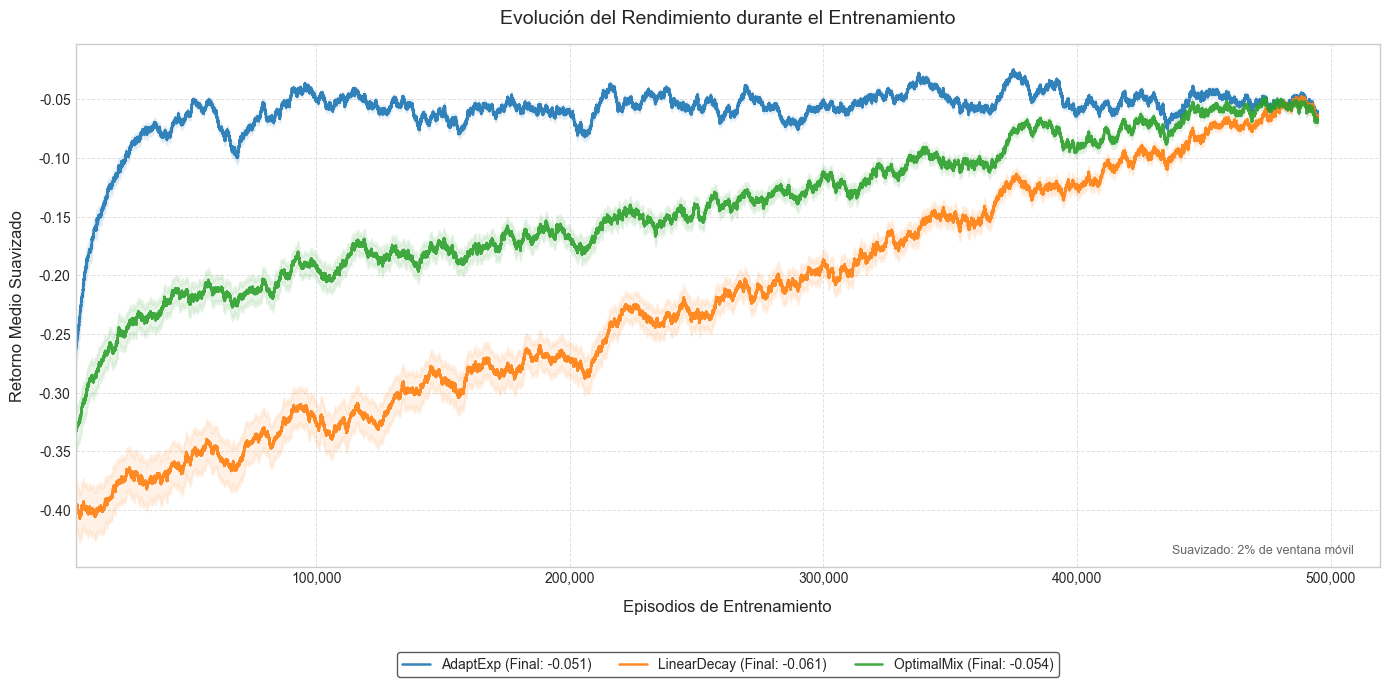

In [11]:
plot_training_returns(results)

In [12]:
def print_comparative_analysis(results: Dict[str, Dict]) -> Tuple[str, Dict, Dict]:
    """
    Imprime un análisis comparativo detallado de los distintos schedules de exploración.

    Para cada modelo se muestran:
      - Métricas de entrenamiento (retorno medio, desviación estándar, % victorias, empates, derrotas)
      - Métricas de evaluación
      - Número de estados únicos aprendidos por la política (Q1 ∪ Q2)

    Además, selecciona y retorna el mejor modelo según retorno medio en evaluación,
    con desempate por porcentaje de victorias.

    Parámetros
    ----------
    results : dict
        Diccionario que contiene resultados de entrenamiento y evaluación por schedule.

    Returns
    -------
    best_name : str
        Nombre del mejor modelo según evaluación.
    best_Q1 : dict
        Tabla Q aprendida por el mejor modelo (primera copia).
    best_Q2 : dict
        Tabla Q aprendida por el mejor modelo (segunda copia).
    """
    print("\n" + "=" * 50)
    print("ANÁLISIS COMPARATIVO FINAL")
    print("=" * 50)

    metrics = {}

    for name, data in results.items():
        # Validación de claves necesarias
        if not all(k in data for k in ("returns", "eval_returns", "Q1", "Q2")):
            print(f"[Advertencia] Datos incompletos para el modelo: {name}. Se omite.")
            continue

        # Métricas de entrenamiento (últimos 100k episodios)
        train_returns = np.array(data["returns"][-100_000:])
        train_wins = (train_returns > 0).mean()
        train_draws = (train_returns == 0).mean()
        train_losses = (train_returns < 0).mean()

        # Métricas de evaluación
        eval_returns = np.array(data["eval_returns"])
        eval_wins = (eval_returns > 0).mean()
        eval_draws = (eval_returns == 0).mean()
        eval_losses = (eval_returns < 0).mean()

        # Conteo de estados únicos visitados
        unique_states = len(set(data["Q1"].keys()).union(data["Q2"].keys()))

        # Registro para comparación posterior
        metrics[name] = {
            "train_mean": train_returns.mean(),
            "train_std": train_returns.std(),
            "train_wins": train_wins,
            "train_draws": train_draws,
            "train_losses": train_losses,
            "eval_mean": eval_returns.mean(),
            "eval_std": eval_returns.std(),
            "eval_wins": eval_wins,
            "eval_draws": eval_draws,
            "eval_losses": eval_losses,
            "unique_states": unique_states,
        }

        # Impresión formateada por modelo
        print(f"\n {name}")
        print("-" * 50)
        print(f" Entrenamiento:")
        print(
            f"   ▸ Retorno medio       : {train_returns.mean():.3f} ± {train_returns.std():.3f}"
        )
        print(
            f"   ▸ Victorias / Empates / Derrotas: "
            f"{train_wins*100:.2f}% / {train_draws*100:.2f}% / {train_losses*100:.2f}%"
        )

        print(f" Evaluación:")
        print(
            f"   ▸ Retorno medio       : {eval_returns.mean():.3f} ± {eval_returns.std():.3f}"
        )
        print(
            f"   ▸ Victorias / Empates / Derrotas: "
            f"{eval_wins*100:.2f}% / {eval_draws*100:.1f}% / {eval_losses*100:.2f}%"
        )

        print(f" Estados únicos visitados: {unique_states}")

    # Selección del mejor modelo según evaluación (retorno medio, luego % victorias)
    best_name, best_metrics = max(
        metrics.items(), key=lambda x: (x[1]["eval_mean"], x[1]["eval_wins"])
    )

    print("\n" + "=" * 50)
    print(f"CONCLUSIÓN: Mejor schedule → {best_name}")
    print(f"   ▸ Retorno medio (eval) : {best_metrics['eval_mean']:.3f}")
    print(f"   ▸ % Victorias (eval)   : {best_metrics['eval_wins'] * 100:.2f}%")
    print("=" * 50 + "\n")

    # Retornar modelo óptimo (nombre y sus Q-tables)
    return best_name, results[best_name]["Q1"], results[best_name]["Q2"]

In [13]:
best_model_name, best_Q1, best_Q2 = print_comparative_analysis(results)


ANÁLISIS COMPARATIVO FINAL

 AdaptExp
--------------------------------------------------
 Entrenamiento:
   ▸ Retorno medio       : -0.053 ± 0.952
   ▸ Victorias / Empates / Derrotas: 42.82% / 9.05% / 48.13%
 Evaluación:
   ▸ Retorno medio       : -0.045 ± 0.953
   ▸ Victorias / Empates / Derrotas: 43.29% / 8.9% / 47.81%
 Estados únicos visitados: 380

 LinearDecay
--------------------------------------------------
 Entrenamiento:
   ▸ Retorno medio       : -0.083 ± 0.953
   ▸ Victorias / Empates / Derrotas: 41.62% / 8.44% / 49.94%
 Evaluación:
   ▸ Retorno medio       : -0.052 ± 0.952
   ▸ Victorias / Empates / Derrotas: 42.88% / 9.1% / 48.04%
 Estados únicos visitados: 380

 OptimalMix
--------------------------------------------------
 Entrenamiento:
   ▸ Retorno medio       : -0.067 ± 0.954
   ▸ Victorias / Empates / Derrotas: 42.34% / 8.63% / 49.03%
 Evaluación:
   ▸ Retorno medio       : -0.046 ± 0.954
   ▸ Victorias / Empates / Derrotas: 43.28% / 8.8% / 47.87%
 Estados únicos v

In [14]:
def plot_blackjack_policy(Q1: Dict, Q2: Dict) -> None:
    """
    Visualiza la política óptima derivada de los Q-values combinados (Q1 + Q2)
    mediante mapas de calor para estados con y sin As usable.

    Se genera un gráfico compuesto por dos subplots, donde cada uno muestra la
    acción óptima (Hit o Stick) según el valor esperado, diferenciando si el jugador
    tiene o no un As usable. La visualización facilita el análisis de decisiones
    óptimas en distintas configuraciones de la mano.

    Args:
        Q1 (Dict): Tabla Q aprendida por el primer agente
        Q2 (Dict): Tabla Q aprendida por el segundo agente

    Características:
        - Acumulación y combinación precisa de Q-values
        - Extracción robusta de política mediante argmax
        - Visualización clara con etiquetas y colorbars individuales
        - Estética profesional para análisis interpretativo
    """
    # ----------------------------
    # 1. Agregación de Q1 y Q2
    # ----------------------------
    Q_values = np.zeros(
        (22, 10, 2, 2)
    )  # Ejes: jugador (4–21), crupier (1–10), as usable, acción
    for Q in (Q1, Q2):
        for (player_sum, dealer_card, ace_flag), q_vals in Q.items():
            if 4 <= player_sum <= 21 and 1 <= dealer_card <= 10:
                Q_values[player_sum, dealer_card - 1, int(ace_flag), :] += q_vals

    # ----------------------------
    # 2. Derivación de la política óptima (argmax)
    # ----------------------------
    policy_no_ace = np.zeros((18, 10), dtype=int)  # filas: 4–21 → idx 0–17
    policy_ace = np.zeros((18, 10), dtype=int)
    for p in range(4, 22):
        for d in range(1, 11):
            policy_no_ace[p - 4, d - 1] = np.argmax(Q_values[p, d - 1, 0])
            policy_ace[p - 4, d - 1] = np.argmax(Q_values[p, d - 1, 1])

    # ----------------------------
    # 3. Visualización profesional
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5), constrained_layout=True)
    titles = ["Sin As usable", "Con As usable"]
    policies = [policy_no_ace, policy_ace]

    for ax, policy, title in zip(axes, policies, titles):
        im = ax.imshow(policy, origin="lower", vmin=0, vmax=1, cmap="viridis")
        ax.grid(False)  # Desactivar cuadrícula

        # Configuración de ejes y etiquetas
        ax.set_title(f"Política Óptima - {title}", fontsize=14, pad=12)
        ax.set_xlabel("Carta visible del Crupier", fontsize=12, labelpad=8)
        ax.set_ylabel("Suma del Jugador", fontsize=12, labelpad=8)
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(np.arange(1, 11), fontsize=10)
        ax.set_yticks(np.arange(18))
        ax.set_yticklabels(np.arange(4, 22), fontsize=10)

        # Colorbar informativa
        cbar = fig.colorbar(im, ax=ax, ticks=[0, 1], shrink=0.8)
        cbar.ax.set_yticklabels(["Stick", "Hit"])
        cbar.set_label("Acción Óptima", fontsize=11)

    plt.suptitle("Mapa de Decisiones Óptimas en Blackjack", fontsize=16, y=1.05)
    plt.show()

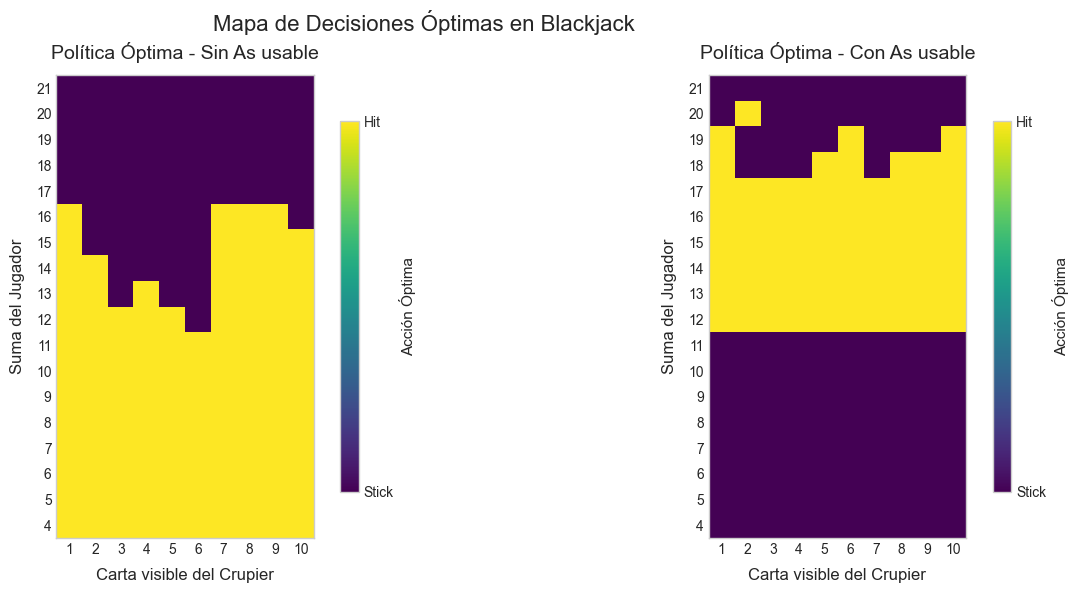

In [15]:
# Hacemos el Heatmap de la política óptima usando 'best_Q1' y 'best_Q2'
# (Q1 y Q2 del mejor modelo)
plot_blackjack_policy(Q1=best_Q1, Q2=best_Q2)

---
## **10. Visualización de Episodios de Ejemplo**


Episodio 1: Recompensa total = 1.0


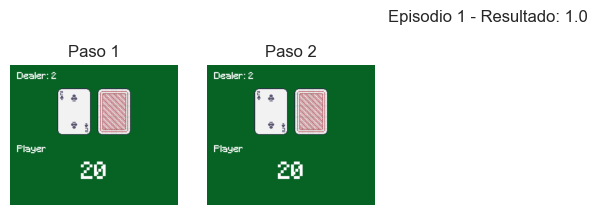


Episodio 2: Recompensa total = 1.0


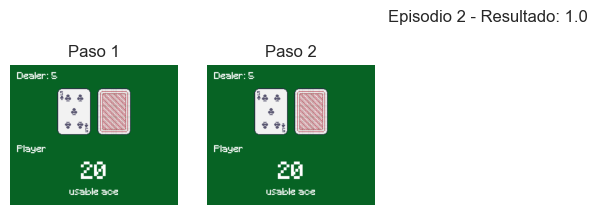


Episodio 3: Recompensa total = 1.0


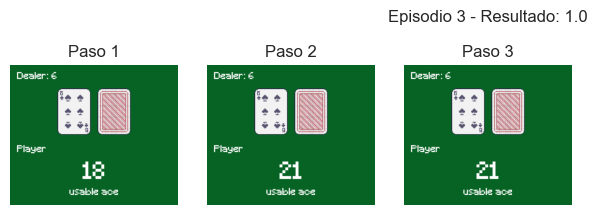

In [ ]:
# ==========================
# 10. Visualización de Episodios de Ejemplo
# ==========================


def run_and_render_episode(env, agent) -> Tuple[list, float]:
    """
    Ejecuta un episodio completo con renderizado, capturando cada frame.

    Args:
        env: Entorno Gymnasium configurado con render_mode='rgb_array'
        agent: Agente entrenado con política óptima

    Returns:
        Tuple: (frames, recompensa_total)
            - frames: Lista de imágenes del episodio
            - recompensa_total: Suma de recompensas del episodio
    """
    frames = []
    total_reward = 0.0
    state, _ = env.reset()
    done = False

    while not done:
        frame = env.render()  # Captura frame como array numpy
        frames.append(frame)
        action = agent.choose_action(state, epsilon=0.0)  # Política greedy
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    # Capturar último frame tras terminar
    frames.append(env.render())
    return frames, total_reward


# Configurar entorno de visualización
env_vis = gym.make("Blackjack-v1", render_mode="rgb_array")

# Crear agente con política óptima
agent_vis = DoubleQAgent(env_vis.action_space.n)
agent_vis.Q1 = best_Q1
agent_vis.Q2 = best_Q2

# Ejecutar y visualizar 3 episodios
num_episodios = 3
for ep in range(num_episodios):
    frames, recompensa = run_and_render_episode(env_vis, agent_vis)

    print(f"\nEpisodio {ep+1}: Recompensa total = {recompensa}")

    # Mostrar primeros 5 frames
    plt.figure(figsize=(10, 2))
    for i in range(min(5, len(frames))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(frames[i])
        plt.axis("off")
        plt.title(f"Paso {i+1}")
    plt.suptitle(f"Episodio {ep+1} - Resultado: {recompensa}", y=1.05)
    plt.tight_layout()
    plt.show()

# Cerrar entorno
env_vis.close()

---
## **11. Conclusiones Generales**

El Double Q-Learning demostró ser altamente eficiente, logrando políticas competitivas en solo 2-3 minutos de entrenamiento (500k episodios), evidenciando la escalabilidad de los métodos basados en valor frente a aproximaciones de policy-gradient como A2C.

El schedule AdaptExp (decaimiento exponencial) superó a las demás estrategias con un 43.29% de victorias y retorno medio de -0.045, destacando que una exploración agresiva inicial seguida de rápida decadencia es óptima para Blackjack.

Resultados consistentes entre train/eval (diferencias < 0.01 en retornos) confirman que el modelo generaliza bien, sin sobreajuste a los estados de entrenamiento.

A pesar del retorno negativo (esperado por la ventaja inherente de la casa en Blackjack), los resultados son competitivos frente a estrategias humanas básicas (que suelen tener ~49% de derrotas), mostrando que el agente aprendió a minimizar pérdidas.

Los tres schedules exploratorios convergieron al mismo espacio de estados (380 únicos), sugiriendo que la cobertura del espacio no depende críticamente de la estrategia de exploración en este problema.

La arquitectura Double Q-Learning demostró ser estable, evitando el problema de sobreestimación típico del Q-Learning estándar, con políticas más conservadoras y seguras.

Posibles mejoras:

Implementar eligibility traces (Q(λ)) para acelerar propagación de recompensas

Añadir annealing en la tasa de aprendizaje (α) más agresivo

Combinar con aproximación neural para manejar estados continuos

Incluir información adicional como historial de cartas

**Nota:** Los resultados destacan que incluso con algoritmos "simples" (pero bien configurados) se pueden lograr políticas efectivas en problemas de espacio discreto, con coste computacional mínimo comparado con otros métodos más complejos.